In [1]:
%matplotlib inline
import mne
mne.viz.set_browser_backend('qt')

Using qt as 2D backend.


In [ ]:
!pip install pycrostates pymatreader


# The ModKmeans object

This tutorial introduces the :class:`pycrostates.clustering.ModKMeans`
structure in detail.


In [2]:
from mne.io import read_raw_eeglab

from pycrostates.datasets import lemon


raw_fname = lemon.data_path(subject_id='010017', condition='EC')
raw = read_raw_eeglab(raw_fname, preload=True)
raw.crop(0, 180)

raw.pick('eeg')
raw.set_eeg_reference('average')

Reading C:\Users\ferat\pycrostates_data\PREPROCESSED_LEMON\sub-010017_EC.fdt
Reading 0 ... 119451  =      0.000 ...   477.804 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


C:\Users\ferat\AppData\Local\Temp\ipykernel_6588\2240026870.py:7: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = read_raw_eeglab(raw_fname, preload=True)
C:\Users\ferat\AppData\Local\Temp\ipykernel_6588\2240026870.py:7: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = read_raw_eeglab(raw_fname, preload=True)


<RawEEGLAB | sub-010017_EC.fdt, 61 x 45001 (180.0 s), ~21.0 MB, data loaded>

In [6]:
raw.plot();

Channels marked as bad:
['PO7']


The modified Kmeans can be instantiated with the number of cluster centers
``n_clusters`` to compute.
A random_state can be defined during class definition in order to have
reproducible results.



In [7]:
from pycrostates.cluster import ModKMeans

n_clusters = 5
ModK = ModKMeans(n_clusters=n_clusters, random_state=42)

Most methods need the modified Kmeans to be fitted. This can be done with
either `mne.io.Raw` or `mne.epochs.Epochs` data structures.
Note that, depending on your setup, you can change ``n_jobs=1`` in order to
use parallel processing and reduce computation time.



In [8]:
ModK.fit(raw, n_jobs=5)

[_base.fit] WARNING: Channel PO7 is set as bad and ignored. To include it, either remove it from 'inst.info['bads'] or provide its name explicitly in the 'picks' argument.
Omitting 397 of 45001 (0.88%) samples, retaining 44604 (99.12%) samples.


100%|███████████████████████████████████████████████████████████████████████████|  : 100/100 [03:35<00:00,    2.16s/it]


[kmeans.fit] INFO: Selecting run with highest GEV = 69.58% after 100/100 iterations converged.


Now that our algorithm is fitted, we can visualize the cluster centers, also
called microstate maps or microstate topographies using `ModK.plot`.
Note than this method uses the `~mne.Info` object of the fitted
instance to display the topographies.



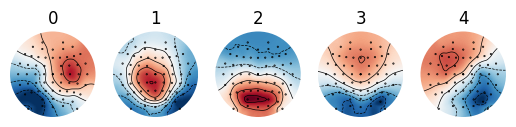

In [9]:
ModK.plot();

One can access the cluster centers as a numpy array thanks to the
``cluster_centers_`` attribute:



## Preprocessing

In [22]:
from pycrostates.preprocessing import extract_gfp_peaks
gfp_data = extract_gfp_peaks(raw, min_peak_distance=1)
gfp_data

Omitting 397 of 45001 (0.88%) samples, retaining 44604 (99.12%) samples.
[extract_gfp_peaks.extract_gfp_peaks] INFO: 5105 GFP peaks extracted out of 44604 samples (11.45% of the original data).


< ChData | 5105 samples >

100%|███████████████████████████████████████████████████████████████████████████|  : 100/100 [00:07<00:00,   13.99it/s]


[kmeans.fit] INFO: Selecting run with highest GEV = 73.93% after 100/100 iterations converged.


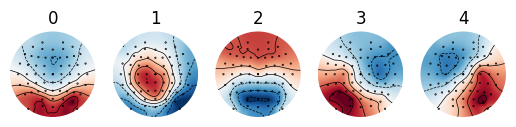

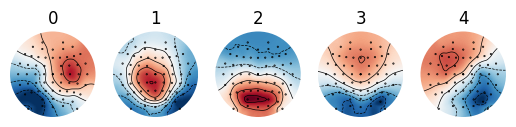

In [11]:
ModK_ = ModKMeans(n_clusters=n_clusters, random_state=42)
ModK_.fit(gfp_data, n_jobs=5)
ModK_.plot(); # gfp
ModK.plot(); #all data

## Optimal number of maps

In [12]:
from pycrostates.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    dunn_score,
    davies_bouldin_score,
)

cluster_numbers = range(2,8)
silhouette_scores = []
calinski_harabasz_scores = []
dunn_scores = []
davies_bouldin_scores = []

for k in cluster_numbers:
    ModK_ = ModKMeans(n_clusters=k, random_state=42)
    ModK_.fit(gfp_data, n_jobs=4)
    # silhouettee
    silhouette_scores.append(silhouette_score(ModK_))
    # calinski and harabasz
    #calinski_harabasz_scores.append(calinski_harabasz_score(ModK))
    # dunn
    #dunn_scores.append(dunn_score(ModK))
    # davies bouldin
    #davies_bouldin_scores.append(davies_bouldin_score(ModK))

100%|███████████████████████████████████████████████████████████████████████████|  : 100/100 [00:09<00:00,   10.17it/s]


[kmeans.fit] INFO: Selecting run with highest GEV = 63.33% after 100/100 iterations converged.


100%|███████████████████████████████████████████████████████████████████████████|  : 100/100 [00:09<00:00,   10.01it/s]


[kmeans.fit] INFO: Selecting run with highest GEV = 68.56% after 100/100 iterations converged.


100%|███████████████████████████████████████████████████████████████████████████|  : 100/100 [00:09<00:00,   10.18it/s]


[kmeans.fit] INFO: Selecting run with highest GEV = 71.75% after 100/100 iterations converged.


100%|███████████████████████████████████████████████████████████████████████████|  : 100/100 [00:09<00:00,   10.97it/s]


[kmeans.fit] INFO: Selecting run with highest GEV = 73.93% after 100/100 iterations converged.


100%|███████████████████████████████████████████████████████████████████████████|  : 100/100 [00:11<00:00,    8.84it/s]


[kmeans.fit] INFO: Selecting run with highest GEV = 75.52% after 100/100 iterations converged.


100%|███████████████████████████████████████████████████████████████████████████|  : 100/100 [00:11<00:00,    8.73it/s]


[kmeans.fit] INFO: Selecting run with highest GEV = 76.84% after 100/100 iterations converged.


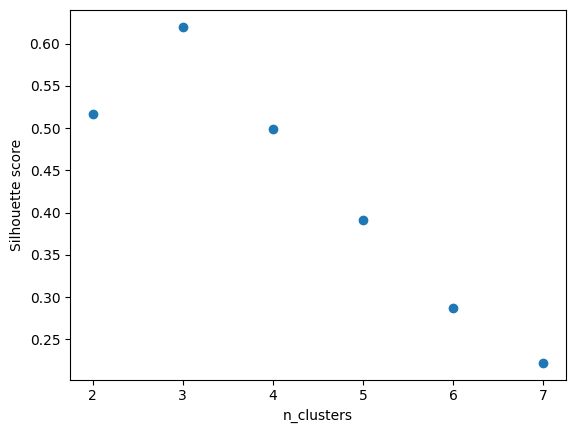

In [13]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(cluster_numbers, silhouette_scores)
plt.xlabel('n_clusters')
plt.ylabel('Silhouette score')
plt.show()

## Segmentation

Clusters centers can be reordered using `ModK.reorder_clusters`:



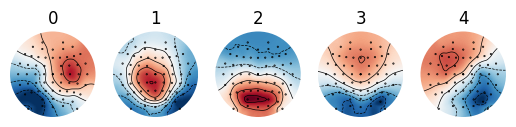

In [14]:
ModK.plot();

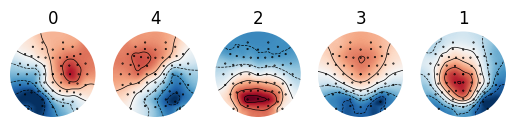

In [15]:
ModK.reorder_clusters(order=[0,4,2,3,1])
ModK.plot();

and renamed using `ModK.rename_clusters`:



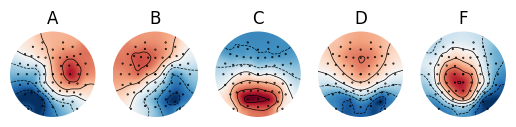

In [16]:
ModK.rename_clusters(new_names=['A', 'B', 'C', 'D', 'F'])
ModK.plot();

Maps polarities can be inverted thanks to `ModK.invert_polarity`
method. Note that it only affects visualization, it has not effect during
backfitting as polarities are ignored.



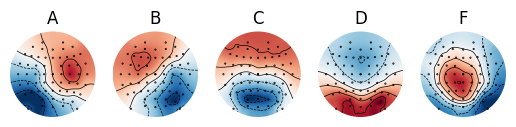

In [17]:
ModK.invert_polarity([False, False, True, True, False])
ModK.plot();

Finally, the modified Kmeans can be used to predict the microstates
segmentation using the `ModK.predict` method. By default, segments
annotated as bad will not be labeled, but this behavior can be changed with
the ``reject_by_annotation`` argument. Smoothing can be performed on the
output sequence by setting the ``factor`` argument ``> 0`` (no smoothing by
default ``factor=0``) while the ``half_window_size`` parameter is used to
specify the smoothing temporal span. Finally, the ``reject_edges`` argument
allows not to assign the first and last segment of each record (or each
epoch) as these can be incomplete. It should have little impact for raw, but
can be important when working with epochs.



[_base.predict] INFO: Segmenting data with factor 10 and effective smoothing window size: 0.0840 (ms).
[_base.predict] INFO: Rejecting segments shorter than 0.0200 (ms).
[_base.predict] INFO: Rejecting first and last segments.
[segmentation._plot_segmentation] INFO: For visualization purposes, the last segment appears truncated by 1 sample. In the case where the last segment is 1 sample long, it does not appear.


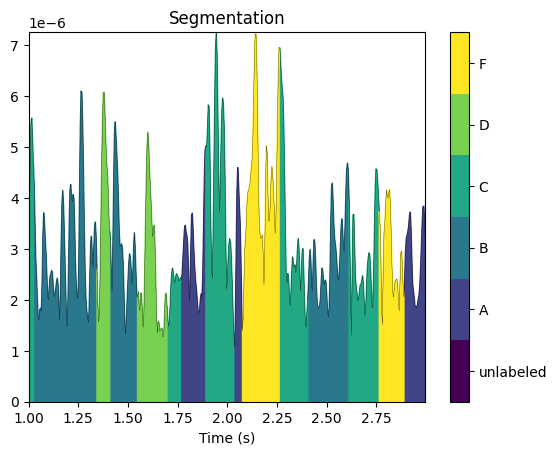

In [19]:
segmentation = ModK.predict(raw,
                            reject_by_annotation=True,
                            factor=10,
                            half_window_size=10, min_segment_length=5,
                            reject_edges=True)
segmentation.plot(tmin=1, tmax=3);

In [18]:
segmentation

<RawSegmentation | n = 5 cluster centers | RawEEGLAB | sub-010017_EC.fdt, 61 x 7501 (30.0 s), ~3.6 MB, data loaded>

In [19]:
segmentation.compute_parameters()

{'A_mean_corr': 0.5201586795427905,
 'A_gev': 0.049652495455658884,
 'A_occurrences': 1.6996748448122967,
 'A_timecov': 0.1591782441619864,
 'A_meandurs': 0.09365217391304345,
 'B_mean_corr': 0.5601772053497636,
 'B_gev': 0.08505005004229875,
 'B_occurrences': 1.8474726574046705,
 'B_timecov': 0.2320425657700266,
 'B_meandurs': 0.12560000000000002,
 'C_mean_corr': 0.653651911119808,
 'C_gev': 0.18255102830698489,
 'C_occurrences': 2.2169671888856044,
 'C_timecov': 0.2627845107892403,
 'C_meandurs': 0.11853333333333332,
 'D_mean_corr': 0.6434237628574817,
 'D_gev': 0.13766673850778324,
 'D_occurrences': 2.0322199231451377,
 'D_timecov': 0.23174697014484186,
 'D_meandurs': 0.1140363636363636,
 'F_mean_corr': 0.5194194032933328,
 'F_gev': 0.030547187213174724,
 'F_occurrences': 1.256281407035176,
 'F_timecov': 0.11424770913390482,
 'F_meandurs': 0.09094117647058823,
 'unlabeled': 0.09798693507532329}